START  →  chat_node  →  END


In [1]:
from langgraph.graph import StateGraph
from typing import TypedDict, Annotated

ModuleNotFoundError: No module named 'langgraph'

In [2]:
from langgraph.graph import StateGraph,START,END

In [3]:
from dotenv import load_dotenv

In [4]:
from langchain_groq import ChatGroq
import os

llm = ChatGroq(
    groq_api_key=os.getenv("GROQ_API"),
    model="llama-3.3-70b-versatile"
)


BaseMessage =
👉 ek chat message ka object
👉 jisme role + content dono hote hain
BaseMessage
 ├── HumanMessage
 ├── AIMessage
 ├── SystemMessage
 └── ToolMessage


Example: BaseMessage vs string
❌ string (problem)
messages = ["hello", "how are you?"]


➡️ LLM ko pata hi nahi:

user bol raha?

assistant?

system instruction?

In [9]:
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [10]:
def chat_node(state:ChatState):
    messages=state['messages']
    response=llm.invoke(messages)
    return {'messages':[response]}

👉 Reducer batata hai: purana state + naya state = final state kaise bane

❌ Reducer ke bina

➡️ purani messages overwrite ho jaayengi

In [11]:
graph = StateGraph(ChatState)

# add nodes
graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile()

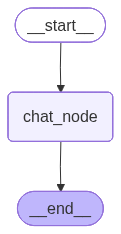

In [12]:
chatbot

In [24]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage
initial_state = {
    'messages': [HumanMessage(content='What is the capital of india')]
}


In [15]:
result = chatbot.invoke(initial_state)
print(result["messages"][-1].content)


The capital of India is New Delhi.


In [16]:
while True:
    user_input = input("You: ")

    if user_input.lower() == "exit":
        print("👋 Chat ended")
        break

    state = chatbot.invoke({
        "messages": [HumanMessage(content=user_input)]
    })

    ai_reply = state["messages"][-1].content
    print("Bot:", ai_reply)

Bot: Hello. It's nice to meet you. Is there something I can help you with or would you like to chat?
Bot: The average distance from the Earth to the Sun is approximately 93 million miles (149.6 million kilometers). This distance is constantly changing due to the elliptical shape of Earth's orbit around the Sun.

At its closest point (called perihelion), the distance between the Earth and the Sun is about 91.5 million miles (147 million kilometers). This typically occurs around early January.

At its farthest point (called aphelion), the distance between the Earth and the Sun is about 94.5 million miles (152.1 million kilometers). This typically occurs around early July.

So, to summarize:

* Average distance: 93 million miles (149.6 million kilometers)
* Closest point (perihelion): 91.5 million miles (147 million kilometers)
* Farthest point (aphelion): 94.5 million miles (152.1 million kilometers)
👋 Chat ended


In [17]:
while True:
    user_input = input("You: ")
     # 👤 User message print
    print("You:", user_input)
    if user_input.lower() == "exit":
        print("👋 Chat ended")
        break

    state = chatbot.invoke({
        "messages": [HumanMessage(content=user_input)]
    })

    ai_reply = state["messages"][-1].content
    print("Bot:", ai_reply)

You: hi
Bot: It's nice to meet you. Is there something I can help you with or would you like to chat?
You: my name is khan
Bot: Nice to meet you, Khan. That's a strong and recognizable name. Is there something I can help you with or would you like to chat?
You: whats my name
Bot: I don't know your name. I'm a large language model, I don't have the ability to recall personal information about individuals, including their names. Each time you interact with me, it's a new conversation and I don't retain any information from previous conversations. If you'd like to share your name with me, I'd be happy to address you by it!
You: exit
👋 Chat ended


“Bhai abhi to naam bataya tha 😭”

👉 LLM problem nahi hai
👉 LangGraph state loop me tum reset kar rahe ho

❌ Galti yahin hai

Har baar tum app.invoke() ko naya state de rahe ho:

messages = [sirf current user message]

Tum soch rahe hoge:

“add_messages reducer to laga hua hai na?”

✔️ Haan
❌ Lekin reducer tab kaam karta hai jab tum purana state pass karo

Tum har baar purana state bhej hi nahi rahe.

In [18]:
state = {"messages": []}

print("🤖 Chatbot ready (type exit to stop)\n")

while True:
    user_input = input("You: ")

    if user_input.lower() == "exit":
        print("👋 Chat ended")
        break

    print("You:", user_input)

    state = chatbot.invoke({
        **state,
        "messages": [HumanMessage(content=user_input)]
    })

    print("Bot:", state["messages"][-1].content)


🤖 Chatbot ready (type exit to stop)

You: helo
Bot: Hello. How can I assist you today?
You: my name is mohan
Bot: Hello Mohan, it's nice to meet you. Is there something I can help you with or would you like to chat?
You: what is my name
Bot: I don't know your name. I'm a large language model, I don't have the ability to know your personal information or recall previous conversations. Each time you interact with me, it's a new conversation. If you'd like to share your name, I'd be happy to chat with you and address you by name.
👋 Chat ended


User sends message
   ↓
Thread ID = "user_123"
   ↓
Memory Server checks:
   → Is thread already present?
       Yes → load old messages
       No  → create new
   ↓
LLM runs
   ↓
Updated memory saved


In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


In [20]:
chatbot = graph.compile(checkpointer=memory)


In [21]:
config = {
    "configurable": {
        "thread_id": "user_1"
    }
}

state = chatbot.invoke(
    {
        "messages": [HumanMessage(content="my name is mohan")]
    },
    config=config
)


In [22]:
state = chatbot.invoke(
    {
        "messages": [HumanMessage(content="what is my name")]
    },
    config=config
)


In [23]:
print("Bot:", state["messages"][-1].content)

Bot: Your name is Mohan.


In [25]:
from langchain_core.messages import HumanMessage

thread_id = "1"

config = {
    "configurable": {
        "thread_id": thread_id
    }
}

print("🤖 Chatbot ready (type exit to stop)\n")

while True:
    user_input = input("You: ")

    if user_input.lower() == "exit":
        print("👋 Chat ended")
        break

    # 👤 User message print
    print("You:", user_input)

    state = chatbot.invoke(
        {
            "messages": [HumanMessage(content=user_input)]
        },
        config=config
    )

    ai_reply = state["messages"][-1].content
    print("Bot:", ai_reply)


🤖 Chatbot ready (type exit to stop)

You: hello
Bot: Hello. It's nice to meet you. Is there something I can help you with or would you like to chat?
You: my name is mohan
Bot: Nice to meet you, Mohan. It's lovely to have you here. How's your day going so far? Is there something on your mind that you'd like to talk about, or would you like some recommendations or help with a particular topic?
You: what is my name
Bot: Your name is Mohan. You told me that earlier.
👋 Chat ended


In [26]:
chatbot.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='5351a2e9-3b2c-426e-9361-3dd86b250a13'), AIMessage(content="Hello. It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 36, 'total_tokens': 61, 'completion_time': 0.057975362, 'completion_tokens_details': None, 'prompt_time': 0.001036518, 'prompt_tokens_details': None, 'queue_time': 0.054218311, 'total_time': 0.05901188}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c06d5113ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b9603-e769-76d1-a258-ae3b9ea9ae35-0', usage_metadata={'input_tokens': 36, 'output_tokens': 25, 'total_tokens': 61}), HumanMessage(content='my name is mohan', additional_kwargs={}, response_metadata={}, id='f9ba8c54-cfae-4a8d-b5aa-aed

📦 Checkpointer kya karta hai?

Checkpointer:

State save karta hai

State load karta hai

Thread ID ke basis pe

thread_id → purana state load
+ naya message add
+ reducer apply
+ LLM call
+ updated state save

Reducer (add_messages) kya karta hai?

👉 ek invoke ke ANDAR

old messages + new messages

Checkpointer kya karta hai?

👉 multiple invokes ke ACROSS

invoke 1 → save
invoke 2 → load
invoke 3 → save